## Introduction

This tutorial will introduce you the whole process of getting data, reformatting data and mining data. This time, I choose to use data that are scraped from Yelp to complete the whole thing. At Yelp, every business obtains many rankings and reviews from customers. As a rule of thumb, there must be some connections between rankings and reviews. Therefore, natural language processing methods are needed here. In this tutorial, I use TF-IDF technology to predict potential rankings from given reviews for Chinese food restaurants in New York.

### Tutorial content

In this tutorial, I will introduce you how to scrape data by using [YelpAPI](https://github.com/gfairchild/yelpapi) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), how to calculate TF-IDF by using [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and how to find connections by using [pairwise_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html).

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Scraping data](#Scraping-data)
- [Reformatting data](#Reformatting-data)
- [Mining data](#Mining-data)
- [Testing data](#Testing-data)
- [Summary](#Summary)

## Installing the libraries

Before we can start, you have to install necessary libraries to support our journey. Fortunately, most of the libraries we need are already installed if you are using anaconda version of python. The only library you need to install manually is [YelpAPI](https://github.com/gfairchild/yelpapi). Install it using `pip`:


    $ pip install yelpapi
    
    

In [1]:
from yelpapi import YelpAPI
import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import heapq 
from nltk.corpus import stopwords 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

## Scraping data

To manipulate data, first we need to get the data. Since we want some useful data from Yelp, why not try YelpAPI which is created specially for scraping from Yelp. With YelpAPI, we don't need any front knowledge like HTTP requests. All we need to do is giving API some parameters and then receive what we want! In order to know what parameters there are, see [Parameters](https://www.yelp.com/developers/documentation/v3/business_search).

However, there is one more preparation we need to do. Notice that Yelp use some authentication to limit our scraper, we have to deliver our identity infomation before establishing connection with Yelp. In this tutorial, I use API Key to authenticate myself. If you don't have one, please visit [Generate API keys](https://www.yelp.com/developers/v3/manage_app) to generate your own API Key. 
Since API Key is very private. I won't show you my API Key here. Instead, you can input your own API Key for the following parameter `Yelp_KEY` if you want to rerun the code next.

In [169]:
Yelp_KEY = 'Please enter your API Key'

Now we can actually begin to collect our data! Here I want to get the urls of restaurants which have more than 1000 reviews in first 150 Chinese restaurants in New York. The reason why I need these urls will be illustrated next. To do so, just use `search_query` function that YelpAPI provides.

In [4]:
yelp_api = YelpAPI(Yelp_KEY,timeout_s=1.5)
url_list = []
for i in range(3):
    search_results = yelp_api.search_query(location='NY',categories='chinese',term='Chinese food',limit=50,offset=i*50)
    for j in range(50):
        if search_results['businesses'][j]['review_count']>=1000:
            url_list.append(search_results['businesses'][j]['url'])

Now, `search_query` stores all the 13 urls we want. Let's see what they look like.

In [171]:
print(len(url_list))
url_list[:3]

13


['https://www.yelp.com/biz/wah-fung-no-1-new-york-2?adjust_creative=X8ALXV4ZcN7s6s_iugIWbw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=X8ALXV4ZcN7s6s_iugIWbw',
 'https://www.yelp.com/biz/joes-shanghai-new-york-2?adjust_creative=X8ALXV4ZcN7s6s_iugIWbw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=X8ALXV4ZcN7s6s_iugIWbw',
 'https://www.yelp.com/biz/noodle-village-new-york-7?adjust_creative=X8ALXV4ZcN7s6s_iugIWbw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=X8ALXV4ZcN7s6s_iugIWbw']

As we can see, YelpAPI can scrape as much business general information as we want, which is delightful. However, things become a little different when scraping reviews. From the [YelpAPI document](https://www.yelp.com/developers/documentation/v3/business_reviews), we are unfortunately informed that we are only able to extract up to 3 reviews for one single restaurant. It is far from enough to build a NLP model. Therefore, we have to use BeautifulSoup to get reviews and rankings.

That is why I need urls of these restaurants, as aforementioned. To make a BeautifulSoup, we first need to use [requests](http://docs.python-requests.org/en/master/) to make HTTP requests. These urls I have can help me visit separate restaurants' websites as the parameter of `get` function.

Since one web page only contains 10 reviews, we have to modify our urls. Notice that we can add `start=offset` at the end of url to turn the page. What's more, the default sort method at Yelp tends to show reviews with high rankings, which is contrary to random sampling. Therefore, I add `sort_by=date_desc` at the end of url in order to make the data distribution more reasonable.

Here we need to scrape 600 pairs of rankings and reviews for each restaurant. Don't forget to wait for a slight moment between two queries in order to avoid getting block.

In [7]:
def scrape_yelp(url):
    ans = []
    #10reviews/page,need 600reviews/restaurant
    for offset in range(60):
        time.sleep(0.2)
        response = requests.get(url+'&sort_by=date_desc&start='+str(offset*10))
        #replace <br> with space
        soup = BeautifulSoup(response.text.replace('<br>',' '), "html.parser")
        for i in soup.find_all('li','margin-b5__373c0__2ErL8 border-color--default__373c0__3-ifU'):
            temp = i.find('div',{'class':re.compile(r'i-stars__373c0__1T6rz i-stars--regular')})
            if temp is None:
                continue
            rank = int(temp.get('aria-label').split(' ')[0])
            review = i.find('span',{'class':'raw__373c0__3rcx7'}).text
            ans.append((rank,review))
    return ans

Finally, we can actually get rankings and reviews from Yelp! Because the whole query is very time-consuming, it took me more than one hours to get all the data. Therefore, for each restaurant's data, I split them into two files for future use. First 80% of data go into `train.txt` and remaining data go into `test.txt`. For each line in files, the first character represents for the ranking and reviews start from the second character to the end.

In [8]:
f1 = open('train.txt', 'wt', encoding='utf-8')
f2 = open('test.txt', 'wt', encoding='utf-8')
for i in range(len(url_list)):
    data = scrape_yelp(url_list[i])
    print(str(i+1)+':'+str(len(data)),end=' ')
    for j in data[:int(len(data)*0.8)]:
        f1.write(str(j[0])+' '+j[1]+'\n')
    for j in data[int(len(data)*0.8):]:
        f2.write(str(j[0])+' '+j[1]+'\n')
f1.close
f2.close

1:590 2:600 3:600 4:600 5:570 6:600 7:600 8:590 9:600 10:600 11:600 12:590 13:570 

<function TextIOWrapper.close()>

Notice that even though I make 60 queries for each restaurant, the result I get is not always 600(60 pages and 10 per page). It is because when we make lots of HTTP requests in a short time, inevitably we will face the situation called [packet loss](https://en.wikipedia.org/wiki/Packet_loss). In this situation, one or two or even more requests will lose, depending on your network environment. Fortunately, we have already got enough data to complete next processes. So it is not a big deal here.

## Reformatting data

Since the review text we just scraped from Yelp is kind of immature, we have to reformat it to make it appropriate for the following mining. After reading the raw text, I notice that there are lots of escape symbols. For example, in the text we have `Where\'s`, we should use [regular expression](https://docs.python.org/3/library/re.html) to finish the translation. Full steps are as followed:
1. Convert the text to lower case.
2. Replace all the `\'` with `'`.
3. Replace all the `'s` with a whitespace.
4. Remove all the `'`.
5. Replace all the `\n`,`\xa0` with a whitespace.
6. Replace all the non-alphanumeric characters with a whitespace.
7. Shrink continuous whitespaces into single whitespace.

In [11]:
def preprocess(line):
    line = line.lower()
    line = re.sub(r'\'','\'',line) #Where\'s -> Where's
    line = re.sub('\'s',r'',line)  #What's -> What
    line = re.sub('\'',r'',line) #don't -> dont
    line = re.sub(r'\n',r' ',line) 
    line = re.sub(r'\xa0',r' ',line)
    line = re.sub(r'[^a-zA-Z0-9]',r' ',line)
    line = re.sub('[\s]+',' ',line)
    return line

Since we have finished `preprocess` function, let's use it to read data from the files we created before. First we read from `train.txt`, store data in list `data`.

In [33]:
f1 = open('train.txt', 'rt', encoding='utf-8')
data = []
for line in f1:
    rank = int(line[0])
    review = preprocess(line[2:])
    data.append((rank,review))
f1.close

<function TextIOWrapper.close()>

Let's see how many data we have for training!

In [34]:
len_train = len(data)
len_train

6168

To have a deep insight into our data, let's plot our data vividly. Here I am curious about how many reviews I have for each ranking(from  1 to 5). We can easily do this by using [matplotlib.pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html).

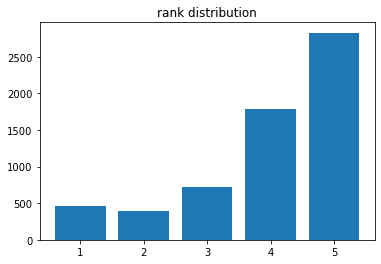

In [35]:
rank = [0,0,0,0,0]
for i in data:
    rank[i[0]-1]+=1
plt.bar([1,2,3,4,5],rank)
plt.title('rank distribution')
plt.show()

As we can see, the amount of reviews with ranking 5 and 4 is far more than other rankings. It can be easily explained. It is because most of the restaurants we scrape from Yelp have the overall ranking between 4 and 5. If here we have the amount of reviews with ranking 1 to be the biggest one, it means these restaurants are so so terrible. Such a set of terrible restaurants is unlikely to be the subset of first 150 restaurants at Yelp in a big city. Therefore, the biased distribution is totally reasonable and doesn't obey randomness. Good news is that around 500 reviews of each low ranking are definitely enough for our goal. 

Because TF-IDF process needs both training and testing data to be in the matrix, now we read data from `test.txt` and append results into `data`.

In [36]:
f1 = open('test.txt', 'rt', encoding='utf-8')
for line in f1:
    rank = int(line[0])
    review = preprocess(line[2:])
    data.append((rank,review))
f1.close

<function TextIOWrapper.close()>

In [38]:
len_test = len(data)-len_train
len_test

1526

Here we can see we have 1526 new items in `data`, which is the amount of all testing data. Since the amount of training data is 6168, we can know the total amount of data we scrape from Yelp is 1526 + 6168 = 7694.

Now we come to the last step of reformatting data. First, we need to add all the reviews into `corpus`, which is necessary for the TF-IDF process. Next, we divide all the data into six groups. For data from `test.txt`, we need to divide them into group 0, which means unknown ranking. Of course we know their rankings, but considering we need them to make prediction, let's pretend that we don't know it just for a while. For data from `train.txt`, we divide them into the group with the group id same to their rankings. Grouped results are stored in dict `rank_group`. There are six keys in `rank_group` and each value stores the list of all the group members' indices in `data`.

In [46]:
corpus = []
rank_group = {0:[],1:[],2:[],3:[],4:[],5:[]}
for i in range(len_train):
    corpus.append(data[i][1])
    rank_group[data[i][0]].append(i)
for i in range(len_train,len(data)):
    corpus.append(data[i][1])
    rank_group[0].append(i)

## Mining data

Until now we have finished all the data preprocessing work, next we can actually mine our data and find some amazing connections among data. Since we have many long texts of reviews and each review has it own ranking, intuitively we can feel that there must be some connection between reviews and rankings. Because reviews contain so many words, a proper [NLP technology](https://en.wikipedia.org/wiki/Natural_language_processing) is needed.

In this tutorial, we will use [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) as the way to mine our data. In a word, TF-IDF is term frequency times inverse document frequency. You can find the formula in [this link](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). It represents the importance of a word in our texts. However, this time we won't calculate TF-IDF manually. With the help of [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), TF-IDF can be quickly acquired.

Before we build our own `TfidfVectorizer`, we need to know a new concept of [stop word](https://en.wikipedia.org/wiki/Stop_word). In our text, there are many too common words, like `is`,`we` and `the`. They contribute nothing to our model and may become noises. These words are called stop words. We can use [nltk.corpus](https://www.nltk.org/api/nltk.corpus.html) to get stopwords set. However, such stopwords set is not installed initially in our laptop. You have to manually download `stopwords.zip` from [here](https://github.com/nltk/nltk_data/tree/gh-pages/packages/corpora) and unzip it to the path `Anaconda\nltk_data\corpora`. After doing so, we can import `stopwords` conveniently from `nltk.corpus`.

In [47]:
stop_words = set(stopwords.words('english')) 

Now we can build our `TfidfVectorizer`. There are so many [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) we can deliver to customize our TfidfVectorizer. Here I use `max_df`, `min_df` and `stop_words` to minimize noises in our data.

In [152]:
vectorize = TfidfVectorizer(max_df=0.4, min_df=5, stop_words=stop_words)
tfidf_matrix = vectorize.fit_transform(corpus)
print(tfidf_matrix.shape)
all_words = vectorize.get_feature_names()

(7694, 4371)


We can see here that our `tfidf_matrix` contains 7694 rows, which is the same as our `data` length and 4371 columns, which is the amount of different useful words in our `corpus`. We can get these words by using `get_feature_names` function and store them into `all_words`.

Since we have built a `tfidf_matrix`, let's see what we can directly get from it. Because tf-idf represents the importance of words, I'd like to see what most important words are in different groups. Just add different rows in same group and use [heapq](https://docs.python.org/3/library/heapq.html) to sort the result. Common sort can only give us values, but using heapq we can get indices, which is useful to locate data from `all_words`.

In [136]:
tfidf_array = tfidf_matrix.toarray()
for i in range(1,6):
    print(str(i)+':',end=' ')
    common = [0]*len(all_words)
    for j in rank_group[i]:
        common = [common[k]+tfidf_array[j][k] for k in range(len(all_words))]
    index_list = map(common.index, heapq.nlargest(50, common))
    for j in index_list:
        print(all_words[j],end=' ')
    print()

1: us never rude bad waiter asked worst terrible horrible said ever disappointed taste know experience tip table take give could customer told went half coming disgusting minutes quality going bao tasted wont used staff another say made delivery star want money gave took times reviews sorry bland leave attitude extremely 
2: taste disappointed wasnt way bland mediocre salty bao us bad okay reviews took table ok many disappointing quality tasted dumpling used hot hype went experience take average nothing wont since however made sure prices dan price say skin never two cheap gave asked years else cold thing understand could authentic 
3: taste okay ok wasnt dan bad though overall however bit nothing us still table way think average decent maybe salty shrimp stars take nice went could lot bland probably roast dumpling broth price sure around hot give bao special tasty prices small used line felt know quality find youre places 
4: dan bit cash tasty nice roast authentic shrimp spot cheap s

In the output, we have 50 most important words for each group. Let's just focus on adjectives and see what we can find.
1. rude, bad, worst, terrible, horrible, disappointed, disgusting, bland
2. disappointed, bland, mediocre, salty, bad, disappointing
3. okay, ok, bad, salty, nice, bland, special
4. nice, flavorful, worth, favorite, fresh, right
5. favorite, worth, fresh, flavorful, nice, excellent, perfect, friendly, loved

As we can see, the above list is just like a ranking for adjectives describing from worst to best. For reviews with ranking 1, adjectives are terrible and horrible, while for reviews with ranking 5, words change to excellent and perfect. Therefore, we can know there are really some connections between reviews and rankings, and our `TfidfVectorizer` does work!

In order to quantify such connections, we will use [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)(PCC) here. It can measure the linear correlation between data. Its formula is very similar to the way we calculate [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). To help with your comprehension, you can just regard it as a normalized version of cosine similarity. All the values are between -1 and 1. Closer to 1 the absolute value is, stronger the relation between two data. Fortunately, we don't bother to calculate PCC manually. We only need to use [pairwise_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html) function from `sklearn`.

In [153]:
pearson = 1-pairwise_distances(tfidf_matrix, metric="cosine")
pearson

array([[1.        , 0.04094508, 0.23812962, ..., 0.11391017, 0.02348288,
        0.01930431],
       [0.04094508, 1.        , 0.07597318, ..., 0.        , 0.02844406,
        0.03532278],
       [0.23812962, 0.07597318, 1.        , ..., 0.01407753, 0.10587301,
        0.02310784],
       ...,
       [0.11391017, 0.        , 0.01407753, ..., 1.        , 0.01692119,
        0.        ],
       [0.02348288, 0.02844406, 0.10587301, ..., 0.01692119, 1.        ,
        0.03310031],
       [0.01930431, 0.03532278, 0.02310784, ..., 0.        , 0.03310031,
        1.        ]])

## Testing data

Finally, we can predict rankings for the reviews in `test.txt`! What we need to do is to calculate the mean pearson correlation coefficient of each ranking group for every ungrouped review. The ranking group that has biggest PCC is the final group we predict the review should be in. Since we have the actual ranking of testing reviews, we can compare the actual value with predicted value to judge how well our work is. 

Notice that `test_result` function has a parameter `thre`. It allows us to change the precision of the results. If `shre` is 0, it means the predicted value can be regarded as the right answer only when it is exactly the same as actual value. If `shre` is 1, it means if actual value is 5, both 4 and 5 can be regarded as the right answer. The reason why I set parameter `shre` will be illustrated further.

In [162]:
def test_result(thre):
    right = 0
    wrong = 0
    for i in rank_group[0]:
        x = [0,0,0,0,0]
        for j in range(5):
            for k in rank_group[j+1]:
                x[j]+=pearson[i][k]
        x[0]/=len(rank_group[1])
        x[1]/=len(rank_group[2])
        x[2]/=len(rank_group[3])
        x[3]/=len(rank_group[4])
        x[4]/=len(rank_group[5])
        predict = x.index(max(x))+1
        if(abs(predict-data[i][0])<=thre):
            right+=1
        else:
            wrong+=1
    print('right:'+str(right))
    print('wrong:'+str(wrong))

First, let's set `shre` = 0 and see what the result is.

In [163]:
test_result(0)

right:784
wrong:742


Well, the result seems not good here, even though the correct percent is beyond 50%. Notice it is not a two-category problem. We have 5 categories, so such a correct percent is totally acceptable. 

However, it is always good to find out why the result is not perfect. Let's try to set `shre` = 1 and see how the result changes.

In [164]:
test_result(1)

right:1406
wrong:120


Wow! The result changes so dramatically. And now it seems definitely good for me. But why can changing `shre` generate two different results?

Let's go back to the list of most important adjective words for each group we concluded before. For your convenience, I will paste it here again.
1. rude, bad, worst, terrible, horrible, disappointed, disgusting, bland
2. disappointed, bland, mediocre, salty, bad, disappointing
3. okay, ok, bad, salty, nice, bland, special
4. nice, flavorful, worth, favorite, fresh, right
5. favorite, worth, fresh, flavorful, nice, excellent, perfect, friendly, loved

As we can see, there is actually no explicit dividing line between two adjacent ranking groups. For example, group 1 and 2 have overlapping words `disappointed`, `bad`, `bland`, as well as group 4 and 5 have overlapping words `nice`, `flavorful`, `favorite`, etc. This can explain why the result is not that good when `shre` = 0. From the perspective of individual words, the adjacent two groups are too similar. TF-IDF technology can not tell which one of two groups is the right answer. That also explains why our result is close to 50%, because now the problem degenerates into something like 2-category problem.

However, things change when `shre` = 1. This time we don't force TF-IDF to give us one exact group id. Just find out the adjacent group is ok. Now we get a very reasonable result. The similarity of two adjacent groups is far bigger than nonadjacent groups. Therefore, the expected result is more accurate. Let's try `shre` = 2 and see if the result could be more perfect.

In [166]:
test_result(2)

right:1491
wrong:35


As we expected, the result now becomes more satisfactory. However, for a problem with 5 categories, setting `shre` as 2 seems too merciful. Just set `shre` as 1 and we can get our final reasonable result.

## Summary

This tutorial introduces the whole process from getting data to verifying the work. Together we successfully accomplished the task of predicting review's ranking by using `TF-IDF`. As we mentioned, the reviews are too subjective, it is possible that somebody says "I like the food very much!" and then gives ranking 4 instead of 5. In addtion, TF-IDF only focuses on individual word itself, neglecting semantic aspects. Thus, TF-IDF can not give the exact accurate predicted rankings. Maybe you can try other NLP methods, such as [n-gram](https://en.wikipedia.org/wiki/N-gram) and [word2vec](https://en.wikipedia.org/wiki/Word2vec), to deal with the problem. However, if you just consider there are three groups: `excellent`, `so-so` and `horrible`, TF-IDF here will give you perfect answer as you expected.